In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from tqdm import tqdm_notebook as tqdm
from PIL import Image

In [2]:
import warnings
warnings.filterwarnings('ignore', message='To copy construct from a tensor')

In [3]:
torch.set_default_tensor_type(torch.DoubleTensor)

In [4]:
# import os
# files = os.listdir('images')

# for i, f in enumerate(files):
#     old_name = f'gray/{f}'
#     new_name = f'gray/gray{i:02}.jpg'
#     !mv $old_name $new_name

In [5]:
def load_image(filename):
    # loads an image in grayscale
    # returns a 2D array (height x width) of intensities between 0 and 1
    img = np.asarray(Image.open(filename).convert('L')) / 255.0
    return torch.tensor(img)

def show_image(arr):
    # Takes in an gray image with intensities from 0 to 1
    arr = np.array(arr)
    arr = (arr * 255).astype(np.uint8)
    scaling = 500 / arr.shape[1]
    
    upscaled = (int(arr.shape[1] * scaling), int(arr.shape[0] * scaling))
    display(Image.fromarray(arr).resize(upscaled))

In [6]:
img = load_image('images/gray00.jpg')

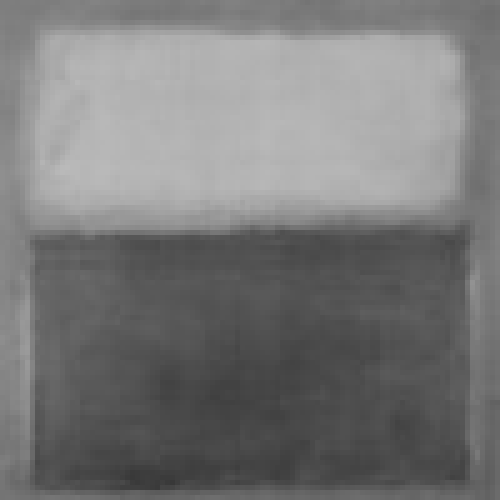

In [7]:
show_image(img)

In [8]:
# generate a fake image from f(x, y) = exp(x) + exp(y)
img = torch.zeros((10, 10))
for x in range(10):
    for y in range(10):
        img[x][y] = np.exp(x) + np.exp(y)

In [9]:
def boundary_conditions_idx(f):    
    boundary_conditions_y = []
    boundary_conditions_x = []
    
    for y in range(f.shape[0]):
        boundary_conditions_y += [y, y]
        boundary_conditions_x += [0, -1]
    
    for x in range(f.shape[1]):
        boundary_conditions_y += [0, -1]
        boundary_conditions_x += [x, x]

    return boundary_conditions_y, boundary_conditions_x

In [10]:
class SecondOrderDiffEq:
    """
    A class that evaluates 2nd order diffential equations of 2 variables
    using a discrete finite difference
    """
    def __init__(self, weights=None):        
        # the 9 weights in the 2nd order PDE of 2 variables correspond to (in order):
        # constant, y, x, f, f_y, f_x, f_yy, f_yx, f_xx
        num_weights = 9
        
        if weights is None:
            weights = torch.randn(num_weights, requires_grad=True)
        
        assert len(weights) == num_weights
        self.weights = torch.tensor(weights, requires_grad=True)

    def freeze(self):
        """
        Returns a copy of the DiffEq with weights that don't require grad
        """
        res = SecondOrderDiffEq(self.weights.clone().detach())
        res.weights.requires_grad = False
        return res
    
    def __call__(self, f):
        """
        Evaluate this DiffEq with the given values of the function value `f`
        This uses a discrete finite difference.
        
        `f` should be a 2D torch.tensor
        """
        assert len(f.shape) == 2, 'expected a 2d matrix'
        
        if not isinstance(f, torch.Tensor):
            f = torch.tensor(f)
        f = f.clone()
        
        coords, _ = zip(*np.ndenumerate(f.detach()))
        x_coords, y_coords = torch.tensor(coords).T
        x_coords = x_coords.reshape(f.shape).double()
        y_coords = y_coords.reshape(f.shape).double()
        
        constant = torch.ones(f.shape)
        
        finite_diffs = []
        
        # compute the first order finite differences
        f_y = torch.zeros(f.shape)
        for y in range(1, f.shape[0] - 1):
            f_y[y] = (f[y + 1] - f[y - 1]) / 2;
        
        f_x = torch.zeros(f.shape)
        for x in range(1, f.shape[1] - 1):
            f_x[:,x] = (f[:, x + 1] - f[:, x - 1]) / 2
        
        
        # compute the second order finite differences
        f_yy = torch.zeros(f.shape)
        for y in range(1, f.shape[0] - 1):
            f_yy[y] = (f[y + 1] - 2*f[y] + f[y - 1]) / 1
        
        f_xx = torch.zeros(f.shape)
        for x in range(1, f.shape[1] - 1):
            f_xx[:,x] = (f[:, x + 1] - 2*f[:, x] + f[:, x - 1]) / 1
        
        f_xy = torch.zeros(f.shape)
        f_yx = torch.zeros(f.shape)        
        for y in range(1, f.shape[0] - 1):
            for x in range(1, f.shape[1] - 1):
                # TODO: optimize this to not be a for loop anymore
                a = f[y+1, x+1] - f[y+1, x-1] - f[y-1, x+1] + f[y-1, x-1]        
                f_xy[y, x] = a / 4
                f_yx[y, x] = a / 4
                
        # set the boundary conditions to be zero
        boundary_y, boundary_x = boundary_conditions_idx(f)
        values = [constant, y_coords, x_coords, f, f_y, f_x, f_yy, f_yx, f_xx]
        for v in values:
            v[boundary_y, boundary_x] = 0
            
        # evaluate the diffeq
        values = torch.stack(values)
        res = self.weights.unsqueeze(1).unsqueeze(2) * values
        return res.sum(dim=0)

In [11]:
def fit_diff_eq(image, num_epochs=1000):
    image = torch.tensor(image).double()
    
    def harcode_boundary(internal_f):
        res = image.clone()
        assert res[1:-1, 1:-1].shape == internal_f.shape
        res[1:-1, 1:-1] = internal_f
        return res
        
    def find_f(diff_eq):
        # make a version of the DiffEq for which the weights
        # do not require_grad
        frozen_diff_eq = diff_eq.freeze()
                
        # set up the "learned" f
        internal_shape = (image.shape[0] - 2, image.shape[1] - 2)
        internal_f = torch.randn(internal_shape, requires_grad=True)
                
        # optimize `internal_f` to minimize the squared error of the diff_eq
        opt = torch.optim.SGD([internal_f], lr=0.005)
        for i in range(num_epochs):
            opt.zero_grad()
            
            f = harcode_boundary(internal_f)
            loss = torch.sum(frozen_diff_eq(f) ** 2)
            loss.backward()
            opt.step()
            
            if loss.detach() < 1e-4:
                break
            
            print(f'Epoch {i} loss: {loss.detach():.3g}')
        
        print('final f:', f)
        
    
    
    diff_eq = SecondOrderDiffEq()
    
    find_f(diff_eq)
    
#     for i in range(max_it):
#         pass
    
    
    return diff_eq

In [12]:
torch.manual_seed(0)
fit_diff_eq(img)

Epoch 0 loss: 1.23e+09
Epoch 1 loss: 1.14e+09
Epoch 2 loss: 1.06e+09
Epoch 3 loss: 9.91e+08
Epoch 4 loss: 9.29e+08
Epoch 5 loss: 8.73e+08
Epoch 6 loss: 8.23e+08
Epoch 7 loss: 7.77e+08
Epoch 8 loss: 7.36e+08
Epoch 9 loss: 6.98e+08
Epoch 10 loss: 6.63e+08
Epoch 11 loss: 6.32e+08
Epoch 12 loss: 6.03e+08
Epoch 13 loss: 5.76e+08
Epoch 14 loss: 5.52e+08
Epoch 15 loss: 5.29e+08
Epoch 16 loss: 5.08e+08
Epoch 17 loss: 4.88e+08
Epoch 18 loss: 4.7e+08
Epoch 19 loss: 4.53e+08
Epoch 20 loss: 4.37e+08
Epoch 21 loss: 4.22e+08
Epoch 22 loss: 4.08e+08
Epoch 23 loss: 3.95e+08
Epoch 24 loss: 3.82e+08
Epoch 25 loss: 3.7e+08
Epoch 26 loss: 3.59e+08
Epoch 27 loss: 3.49e+08
Epoch 28 loss: 3.39e+08
Epoch 29 loss: 3.29e+08
Epoch 30 loss: 3.2e+08
Epoch 31 loss: 3.12e+08
Epoch 32 loss: 3.03e+08
Epoch 33 loss: 2.96e+08
Epoch 34 loss: 2.88e+08
Epoch 35 loss: 2.81e+08
Epoch 36 loss: 2.74e+08
Epoch 37 loss: 2.68e+08
Epoch 38 loss: 2.61e+08
Epoch 39 loss: 2.55e+08
Epoch 40 loss: 2.5e+08
Epoch 41 loss: 2.44e+08
Epoch 

Epoch 347 loss: 3.49e+07
Epoch 348 loss: 3.48e+07
Epoch 349 loss: 3.48e+07
Epoch 350 loss: 3.47e+07
Epoch 351 loss: 3.47e+07
Epoch 352 loss: 3.47e+07
Epoch 353 loss: 3.46e+07
Epoch 354 loss: 3.46e+07
Epoch 355 loss: 3.45e+07
Epoch 356 loss: 3.45e+07
Epoch 357 loss: 3.45e+07
Epoch 358 loss: 3.44e+07
Epoch 359 loss: 3.44e+07
Epoch 360 loss: 3.43e+07
Epoch 361 loss: 3.43e+07
Epoch 362 loss: 3.42e+07
Epoch 363 loss: 3.42e+07
Epoch 364 loss: 3.42e+07
Epoch 365 loss: 3.41e+07
Epoch 366 loss: 3.41e+07
Epoch 367 loss: 3.41e+07
Epoch 368 loss: 3.4e+07
Epoch 369 loss: 3.4e+07
Epoch 370 loss: 3.39e+07
Epoch 371 loss: 3.39e+07
Epoch 372 loss: 3.39e+07
Epoch 373 loss: 3.38e+07
Epoch 374 loss: 3.38e+07
Epoch 375 loss: 3.38e+07
Epoch 376 loss: 3.37e+07
Epoch 377 loss: 3.37e+07
Epoch 378 loss: 3.37e+07
Epoch 379 loss: 3.36e+07
Epoch 380 loss: 3.36e+07
Epoch 381 loss: 3.36e+07
Epoch 382 loss: 3.35e+07
Epoch 383 loss: 3.35e+07
Epoch 384 loss: 3.35e+07
Epoch 385 loss: 3.34e+07
Epoch 386 loss: 3.34e+07
Ep

Epoch 688 loss: 2.9e+07
Epoch 689 loss: 2.9e+07
Epoch 690 loss: 2.9e+07
Epoch 691 loss: 2.9e+07
Epoch 692 loss: 2.9e+07
Epoch 693 loss: 2.9e+07
Epoch 694 loss: 2.9e+07
Epoch 695 loss: 2.9e+07
Epoch 696 loss: 2.9e+07
Epoch 697 loss: 2.9e+07
Epoch 698 loss: 2.9e+07
Epoch 699 loss: 2.89e+07
Epoch 700 loss: 2.89e+07
Epoch 701 loss: 2.89e+07
Epoch 702 loss: 2.89e+07
Epoch 703 loss: 2.89e+07
Epoch 704 loss: 2.89e+07
Epoch 705 loss: 2.89e+07
Epoch 706 loss: 2.89e+07
Epoch 707 loss: 2.89e+07
Epoch 708 loss: 2.89e+07
Epoch 709 loss: 2.89e+07
Epoch 710 loss: 2.89e+07
Epoch 711 loss: 2.89e+07
Epoch 712 loss: 2.89e+07
Epoch 713 loss: 2.89e+07
Epoch 714 loss: 2.89e+07
Epoch 715 loss: 2.89e+07
Epoch 716 loss: 2.88e+07
Epoch 717 loss: 2.88e+07
Epoch 718 loss: 2.88e+07
Epoch 719 loss: 2.88e+07
Epoch 720 loss: 2.88e+07
Epoch 721 loss: 2.88e+07
Epoch 722 loss: 2.88e+07
Epoch 723 loss: 2.88e+07
Epoch 724 loss: 2.88e+07
Epoch 725 loss: 2.88e+07
Epoch 726 loss: 2.88e+07
Epoch 727 loss: 2.88e+07
Epoch 728 l